In [20]:
import os
path = os.getcwd().removesuffix('/evaluate')
os.chdir(path)
from algorithm.model import *
import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import pytorch_lightning as pl
from algorithm import *
from helpers import *
from algorithm.metrics import get_corr


acc_chance = 0.05

import matplotlib
import matplotlib.colors as clr
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.dpi"]=200


In [21]:
#next steps: vosualize network activity in ORN, PN, KC separately as in Nanami et al. (2024)

In [22]:
def get_voltages(settings,student, pre_path='', mode='test'):

    dt=settings.time_step
    student.call_outside_loop=True

    trainloader, valloader, testloader, nb_steps = choose_data_params(
        data_set_name, settings, num_workers=0,pre_path=pre_path
    ) 
    data_module = DataModule(trainloader, valloader, testloader)
    data_module.setup(stage=mode)  # make sure train/val/test data is prepared
    test_loader = data_module.test_dataloader()
    print(next(iter(test_loader)))
    test_batch = next(iter(test_loader))
    inputs, target, duration = test_batch

    mems= (-student.model.time_step/torch.log(student.model.beta)).cpu().detach().numpy() #tau_mem

    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    inputs = inputs.to(device)
    target = target.to(device)
    
    student.model.eval()

    output, [mem_rec,spk_rec]=student.model.forward(inputs,target)

    return inputs, mem_rec, spk_rec, output, target, duration

In [23]:
#oi
data_set_name='olfactory'
i=0
j=0
teacher_params='wi'
train_params='oi'
train_loss='nll'
train_layer='hil'
pre_path = 'data/ORN_data/samples'

hil=0.0
teacher_low_rank_sparse=None
teacher_weight_init='normal'
teacher_neuron_model='LIF'#'BLK_nonsp' 'LIF'
teacher_sparsity=0.5
neuron_model='LIF'#'BLK_nonsp'
synapse_name='recurrent_synapse'
seed=None
config_path = 'fruitfly'

settings = Config(data_set_name,settings_file=config_path)
settings.weight_scaling_factor=0.2
settings.target_weights=None
print(f'\n\n wsf: {settings.weight_scaling_factor}\n\n')
settings.weight_info=settings.train_weights,settings.Dales_law,settings.weight_init_,settings.target_weights,settings.weight_scaling_factor,settings.recurrent_sparse,settings.low_rank_sparse
neuron_synapse=f'{settings.neuron_name}_{settings.synapse.__name__}'

size_string=get_size_str(settings.batch_size,settings.nb_inputs,settings.nb_outputs)
data_module =choose_data_params(
        data_set_name, settings, num_workers=4,pre_path=pre_path
    ) 

teacher = None 
# new instance of model
model = Lightning_SNN(
        net_size=settings.net_size,
        neuron_fct=settings.neuron_fct,
        neuron_intrinsic=settings.neuron_intrinsic,
        synapse_intrinsic=settings.synapse_intrinsic,
        train_intrinsic=settings.train_intrinsic,
        clip_intrinsic=settings.clip_intrinsic,
        regularizers=settings.regularizers,
        train_out=settings.train_out,
        train_hidden=settings.train_hidden,
        weight_info=settings.weight_info,
        nr=i,
        learning_rate=settings.learning_rate,
        time_step=settings.time_step,
        optim_class=settings.optim_class,
        optim_params=settings.optim_params,
        scheduler=settings.scheduler,
        surr_grad_scale=settings.surr_grad_scale,
        adapt_intrinsic=False,#TODO
        tau_mem_LIF=settings.tau_mem,
        training_mode = settings.training_mode,
        hidden_mode=settings.hidden_mode,
        target_model = settings.target_model,
        params_from_target = settings.params_from_target,
        hidden_in_loss = settings.hidden_in_loss,
        hidden_loss_scale=settings.hidden_loss_scale,
        noise=settings.noise,
        path_info=None,
        N_train_only_weights = settings.N_train_only_weights,
        shuffle=False
    )

#load old model


self.synapse intr noise is 0.0
nb hidden inside config: 7616
self.synapse_noise: 0.0
dims is False
dims is 1
shape in config tau_mem: torch.Size([552])
shape in config beta: torch.Size([552])
config wsf: 1.0


 wsf: 0.2


settings.batch_size: 16
lightning init device cpu
N rec = 0
N unrec = 7616
hidden in loss in SNN are None
first instance of tau_mem in SNN: torch.Size([552])
LIF model with, U_rest 0.0, rest 0.0, tau mem tensor([0.0609, 0.0342, 0.0362, 0.0762, 0.0664, 0.0519, 0.0570, 0.0383, 0.0703,
        0.0530, 0.0422, 0.0716, 0.0630, 0.0694, 0.0359, 0.0653, 0.0591, 0.0588,
        0.0344, 0.0419, 0.0297, 0.0740, 0.0245, 0.0356, 0.0302, 0.0323, 0.0333,
        0.0205, 0.0482, 0.0462, 0.0266, 0.0550, 0.0253, 0.0389, 0.0706, 0.0645,
        0.0250, 0.0319, 0.0634, 0.0277, 0.0367, 0.0638, 0.0278, 0.0331, 0.0735,
        0.0265, 0.0691, 0.0649, 0.0230, 0.0466, 0.0377, 0.0350, 0.0247, 0.0421,
        0.0370, 0.0201, 0.0629, 0.0363, 0.0467, 0.0410, 0.0492, 0.0411, 0.0633,
        0.0351

/Users/mareneberle/Documents/research/projects/summerschool2025/projects/algorithm/config/Config.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.beta = torch.exp(-self.time_step / torch.tensor(self.tau_mem))
/Users/mareneberle/Documents/research/projects/summerschool2025/projects/algorithm/model/fruitfly_olf.py:283: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cell_types["primary_type"] = cell_types["primary_type"].replace(self.replace_ct)
/Users/mareneberle/Documents/research/projects/summerschool2025/projects/algorithm/model/fruitfly_olf.py:360: FutureWarning: Downcasting behavior in `replace` i

model is SNN, is_spiking True
train_intrinsic: ['I_c', 'beta']
2


train weights: True, train_intrinsic: ['I_c', 'beta']


self is student: False
init w2
scale: 1.4142135623730951, std is 0.08391813582966891
model is student: False
init w1
init v


/Users/mareneberle/Documents/research/projects/summerschool2025/projects/algorithm/model/fruitfly_olf.py:361: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  v_df["nt_type"] = v_df["nt_type"].replace(self.replace_nt)


fruit fly weights set up
Parameter name: I_c, requires_grad: True
Parameter name: beta, requires_grad: True
Parameter name: reset, requires_grad: False
Parameter name: nt_values, requires_grad: True
Parameter name: weight_scaling_factor, requires_grad: True
Parameter name: w2, requires_grad: True


using classification loss


train out: True, train hidden: False, self hidden mode is None


In [24]:
#target.shape, inputs.shape
# for shd: input: torch.Size([663, 256, 1, 70]), target: torch.Size([256])
# for olfactory should be roughly: [500,16,1,2000], [16]

In [25]:
inputs, mem_rec, spk_rec,output, target, duration=get_voltages(settings,model, pre_path=pre_path)

settings.batch_size: 16
initializing data module
(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

    

In [40]:
model.model.hidden_neuron_IDs
model.model.input_neuron_IDs

import json

with open('evaluate/broad_cell_types.json') as f:
    broad_cell_types = json.load(f)


def plot_celltype_activity(settings, model_pre,model_post, queries, pre_path):
    input_ids = pd.Series(model_pre.model.input_neuron_IDs)
    hidden_ids = pd.Series(model_post.model.hidden_neuron_IDs)
    batch_idx=0
    inputs_pre, mem_rec_pre, spk_rec_pre,output_pre, target_pre, duration=get_voltages(settings,model_pre, pre_path=pre_path, mode='train')
    inputs, mem_rec, spk_rec,output, target, duration=get_voltages(settings,model_post, pre_path=pre_path, mode='train')
    
    for query in queries:
        plt.figure(figsize=(10,6))
        idx_in = input_ids[input_ids.isin(broad_cell_types[query])].index
        idx_hidden = hidden_ids[hidden_ids.isin(broad_cell_types[query])].index


        spk_in = inputs[:,batch_idx,0,idx_in].detach().numpy()
        N_in=spk_in.shape[1]
        spk_hidden = spk_rec_pre[batch_idx,:,idx_hidden].detach().numpy()
        plt.axvspan(0, duration[batch_idx], facecolor="gray", alpha=0.2, label = 'stimulus presentation')
        if query=='ALRN':
            all_spk = spk_in
        else:
            all_spk = np.hstack([spk_in,spk_hidden])
        T, N_all=all_spk.shape
        #plt.imshow(all_spk.T,cmap='binary',aspect='auto',interpolation='None')
        x_coords, y_coords = np.where(all_spk == 1)
        plt.scatter(x_coords, y_coords, marker=".", s=4)

        
        plt.xlim(0,T)
        plt.ylim(0,N_all)
        plt.xlabel('time [ms]')
        plt.ylabel('neuron')
        plt.title(f'{query} before training')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,6))
        spk_in = inputs[:,batch_idx,0,idx_in].detach().numpy()
        N_in=spk_in.shape[1]
        spk_hidden = spk_rec[batch_idx,:,idx_hidden].detach().numpy()
        plt.axvspan(0, duration[batch_idx], facecolor="gray", alpha=0.2, label = 'stimulus presentation')
        if query=='ALRN':
            all_spk = spk_in
        else:
            all_spk = np.hstack([spk_in,spk_hidden])
        T, N_all=all_spk.shape
        #plt.imshow(all_spk.T,cmap='binary',aspect='auto',interpolation='None')
        x_coords, y_coords = np.where(all_spk == 1)
        plt.scatter(x_coords, y_coords, marker=".", s=4)

        #if N_in > 0 and N_in!=N_all:
            #plt.axhline(y=N_in, color='r', linestyle='-')
        plt.xlim(0,T)
        plt.ylim(0,N_all)
        plt.xlabel('time [ms]')
        plt.ylabel('neuron')
        plt.title(f'{query} after training')
        plt.legend()
        plt.show()



In [27]:
'''hidden_ids = pd.Series(fruitfly.model.hidden_neuron_IDs)
KC_idxs = np.array(hidden_ids[hidden_ids.isin(broad_cell_types['KC'])].index)
np.save('KC_idxs.npy', KC_idxs)
spk_rec[:,:,KC_idxs].shape'''


"hidden_ids = pd.Series(fruitfly.model.hidden_neuron_IDs)\nKC_idxs = np.array(hidden_ids[hidden_ids.isin(broad_cell_types['KC'])].index)\nnp.save('KC_idxs.npy', KC_idxs)\nspk_rec[:,:,KC_idxs].shape"

In [28]:
fruitfly = Lightning_SNN.load_from_checkpoint('/Users/mareneberle/Documents/research/projects/summerschool2025/projects/model_example/fruitfly/epoch=5-val_acc=0.76.ckpt', strict=False, path_info=None, target_model=None).eval()

lightning init device cpu
hidden in loss is 0.0
hidden in loss is <class 'float'>
N hidden provided: 0
len hidden in loss: 0
N rec = 0
N unrec = 7616
hidden in loss in SNN are []
first instance of tau_mem in SNN: torch.Size([552])
LIF model with, U_rest 0.0, rest 0.0, tau mem tensor([0.0429, 0.0493, 0.0362, 0.0582, 0.0340, 0.0736, 0.0401, 0.0351, 0.0706,
        0.0236, 0.0392, 0.0592, 0.0469, 0.0738, 0.0600, 0.0781, 0.0297, 0.0605,
        0.0785, 0.0563, 0.0748, 0.0223, 0.0599, 0.0436, 0.0221, 0.0759, 0.0246,
        0.0778, 0.0584, 0.0570, 0.0425, 0.0532, 0.0626, 0.0382, 0.0740, 0.0334,
        0.0222, 0.0634, 0.0705, 0.0555, 0.0349, 0.0742, 0.0422, 0.0202, 0.0348,
        0.0471, 0.0556, 0.0312, 0.0308, 0.0454, 0.0313, 0.0575, 0.0774, 0.0325,
        0.0314, 0.0455, 0.0288, 0.0697, 0.0475, 0.0517, 0.0508, 0.0269, 0.0668,
        0.0432, 0.0657, 0.0251, 0.0521, 0.0542, 0.0357, 0.0629, 0.0721, 0.0670,
        0.0568, 0.0472, 0.0712, 0.0505, 0.0716, 0.0566, 0.0359, 0.0256, 0.0373,
   

/Users/mareneberle/Documents/research/projects/summerschool2025/projects/algorithm/model/fruitfly_olf.py:283: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cell_types["primary_type"] = cell_types["primary_type"].replace(self.replace_ct)
/Users/mareneberle/Documents/research/projects/summerschool2025/projects/algorithm/model/fruitfly_olf.py:360: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  w1_df["nt_type"] = w1_df["nt_type"].replace(self.replace_nt)


model is SNN, is_spiking True
train_intrinsic: ['I_c', 'beta']
2


train weights: False, train_intrinsic: ['I_c', 'beta']


self is student: False
init w2
scale: 1.4142135623730951, std is 0.08391813582966891
model is student: False
init w1
init v


/Users/mareneberle/Documents/research/projects/summerschool2025/projects/algorithm/model/fruitfly_olf.py:361: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  v_df["nt_type"] = v_df["nt_type"].replace(self.replace_nt)


fruit fly weights set up
Parameter name: I_c, requires_grad: True
Parameter name: beta, requires_grad: True
Parameter name: reset, requires_grad: False
Parameter name: nt_values, requires_grad: False
Parameter name: weight_scaling_factor, requires_grad: True
Parameter name: w2, requires_grad: True


using classification loss


train out: True, train hidden: False, self hidden mode is mse


settings.batch_size: 16
initializing data module
(tensor([[[[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 1.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[1., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 1., 0.,  ..., 0., 0., 0.]],

    

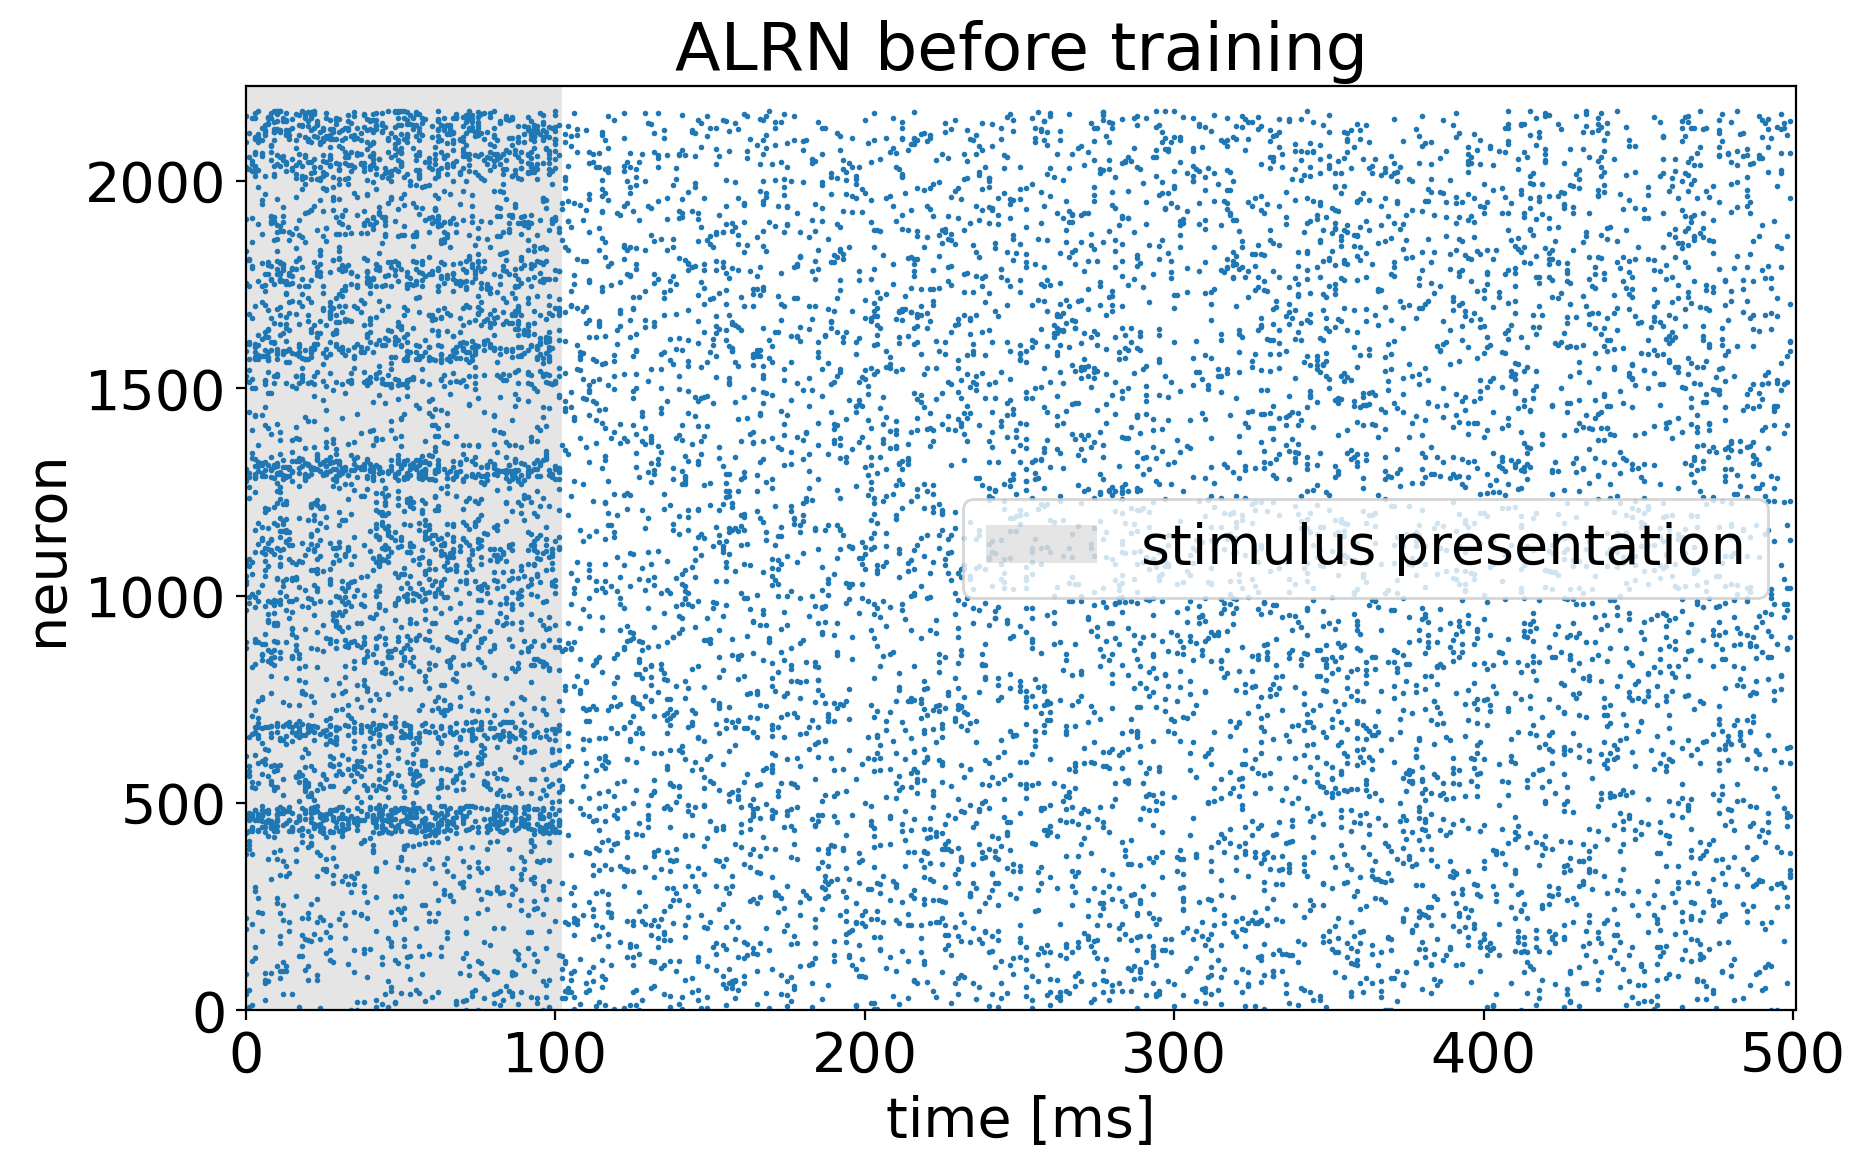

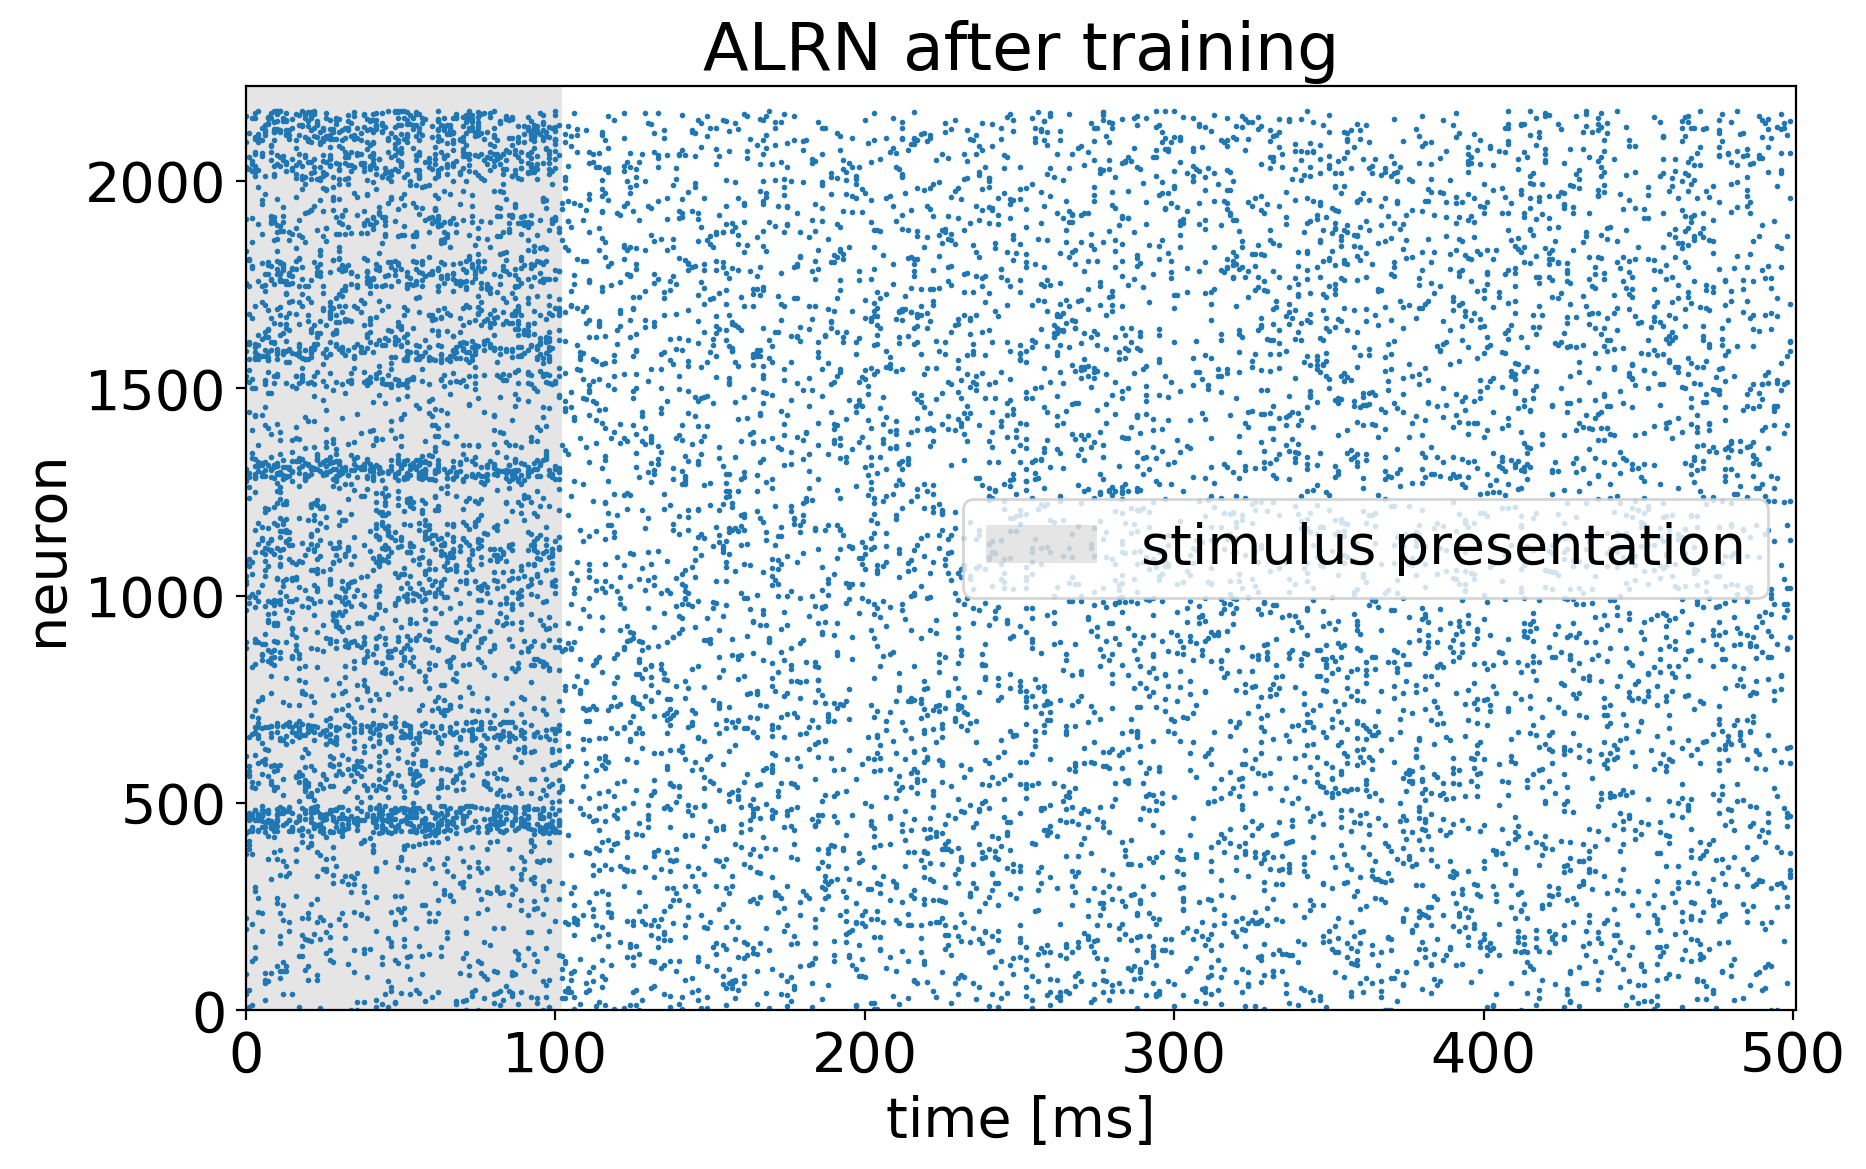

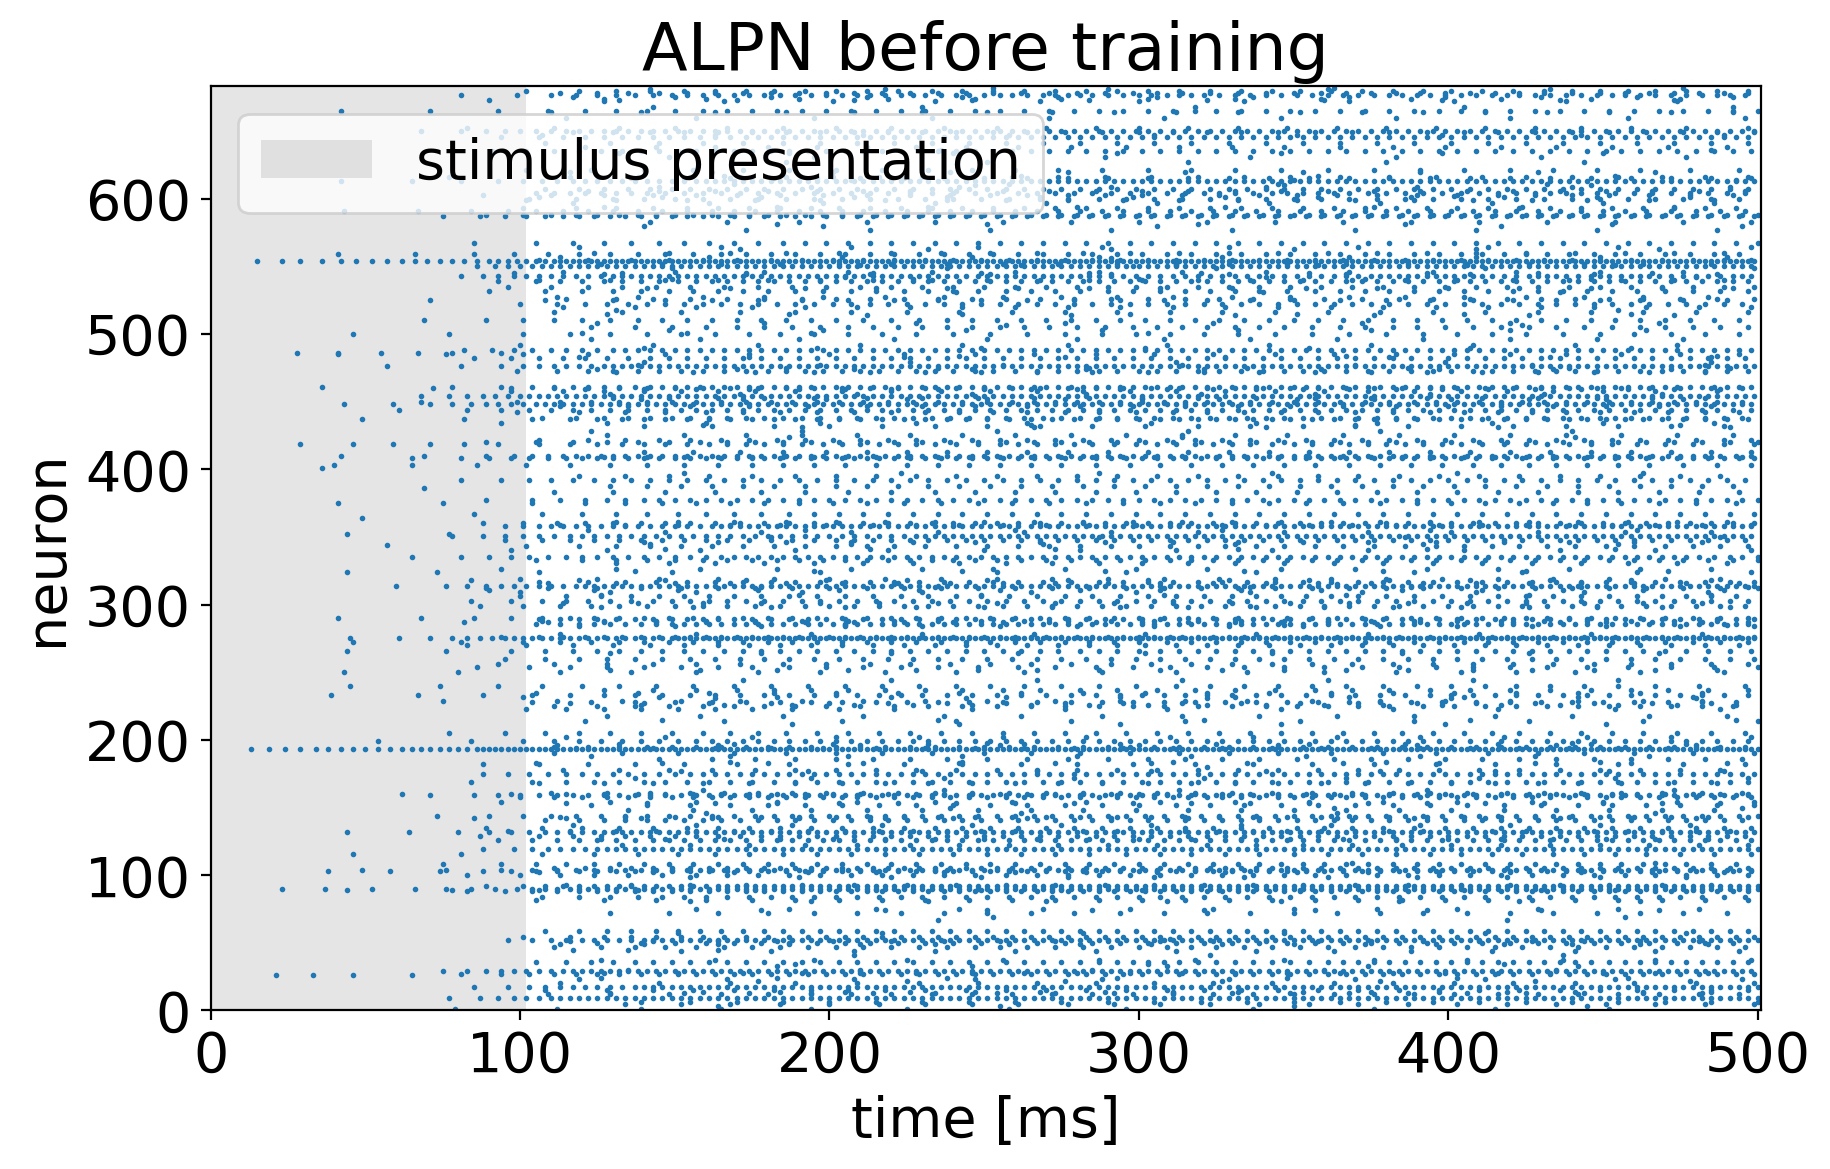

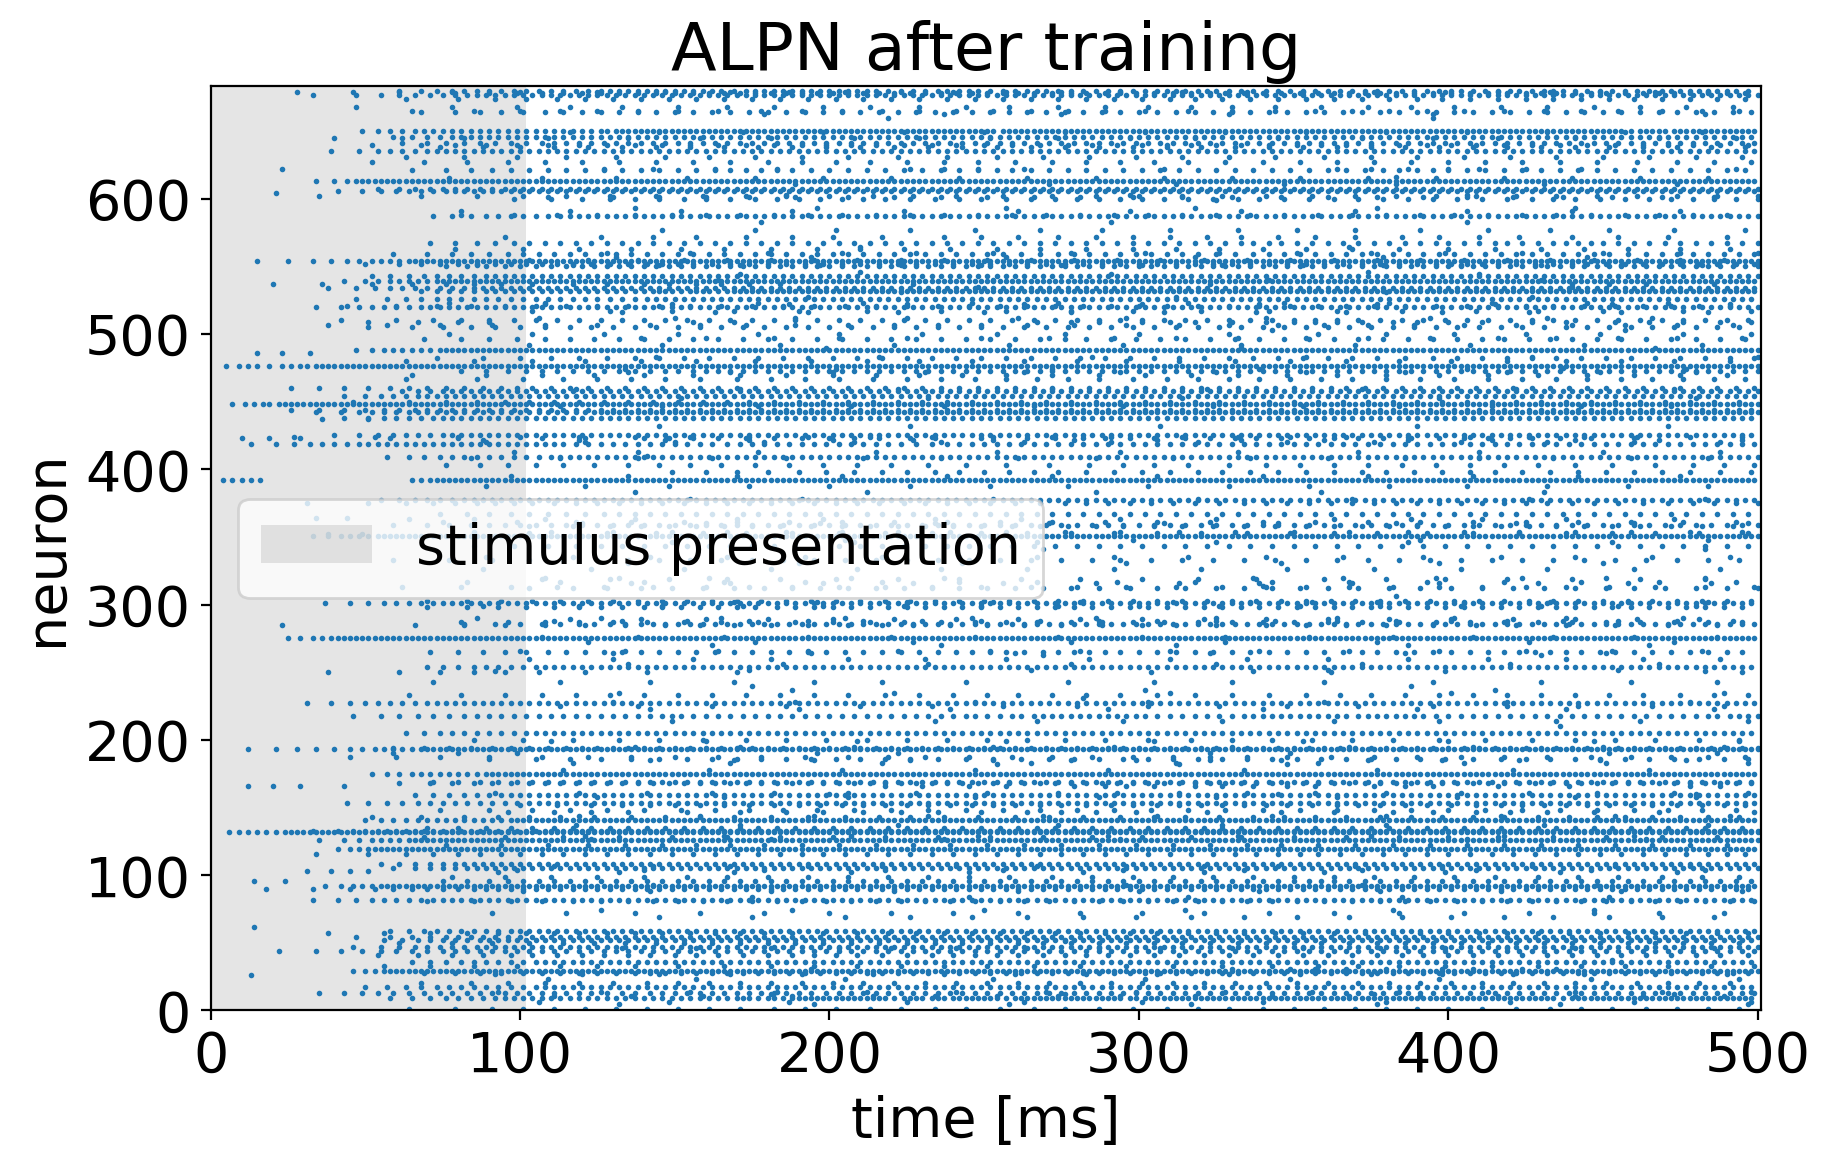

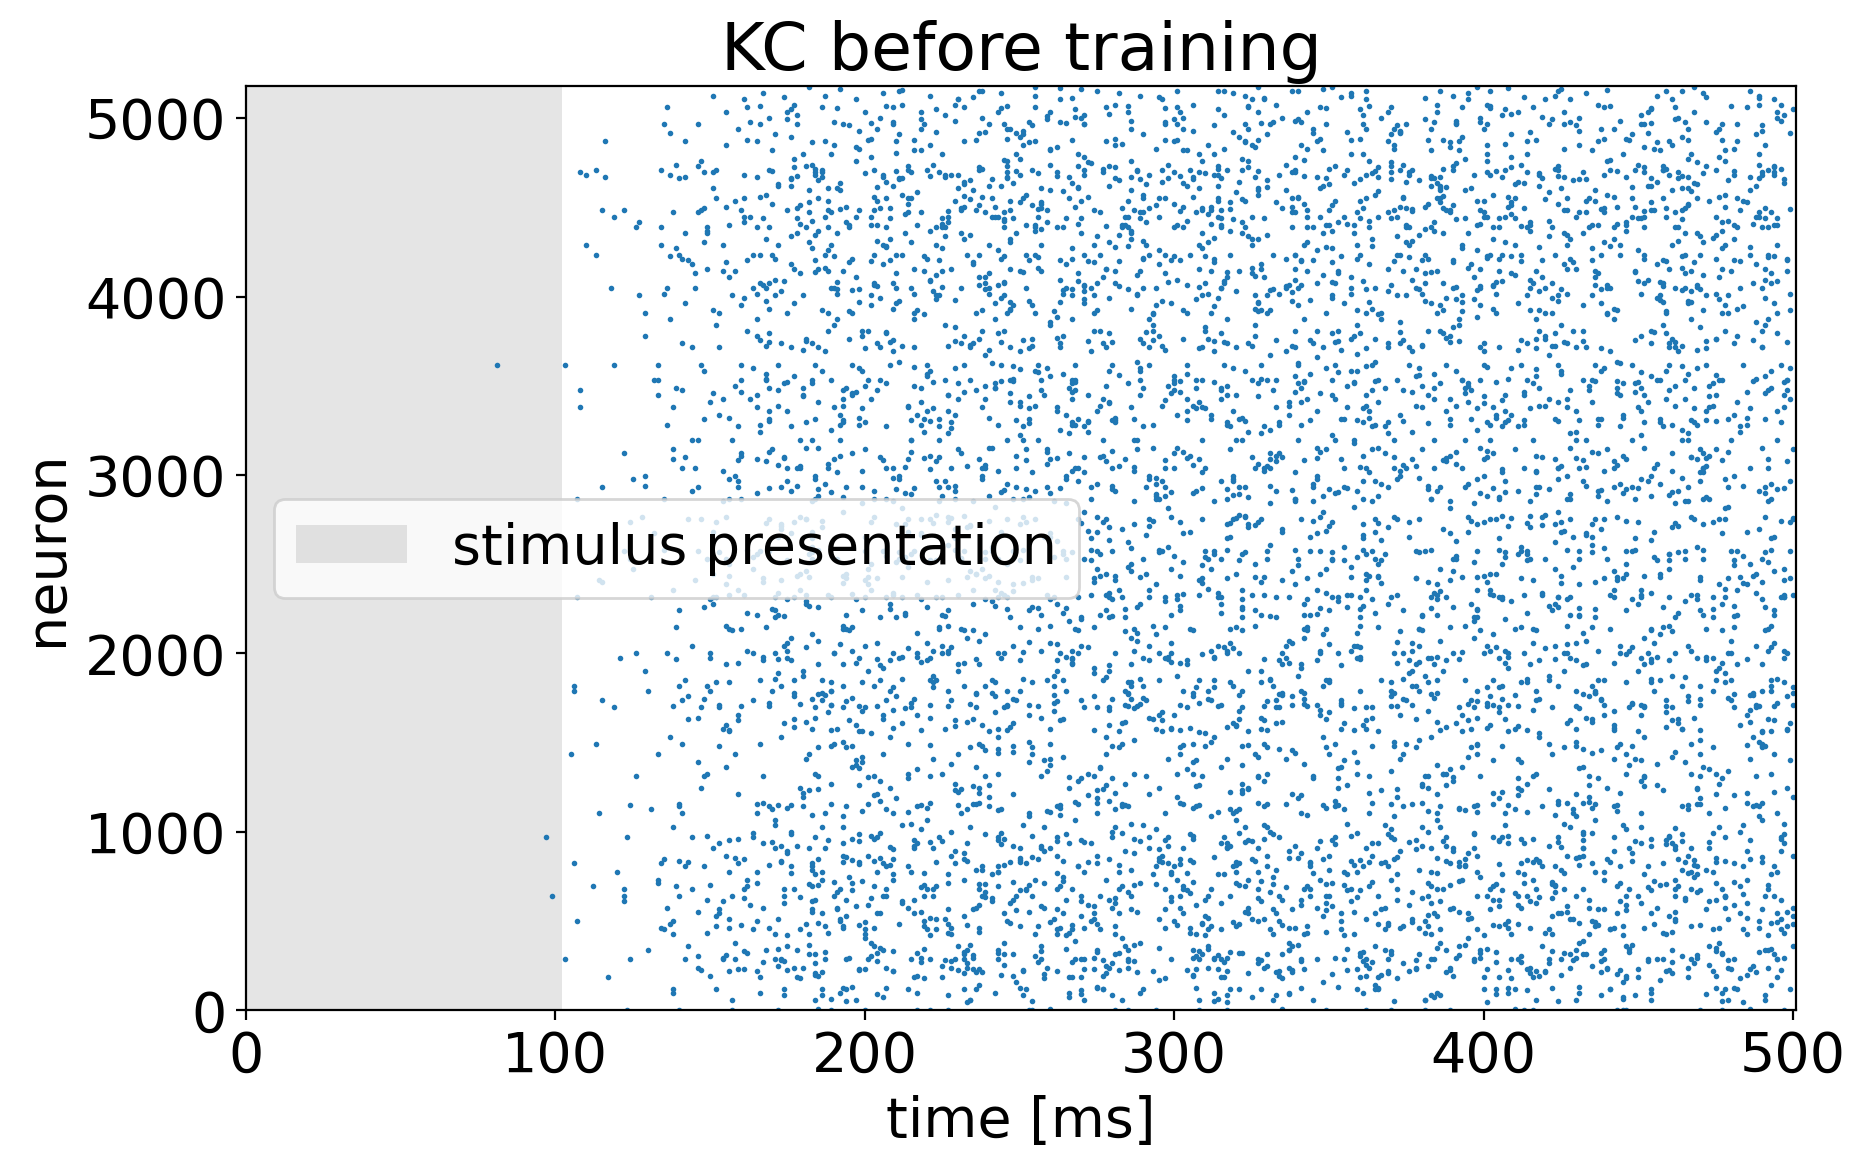

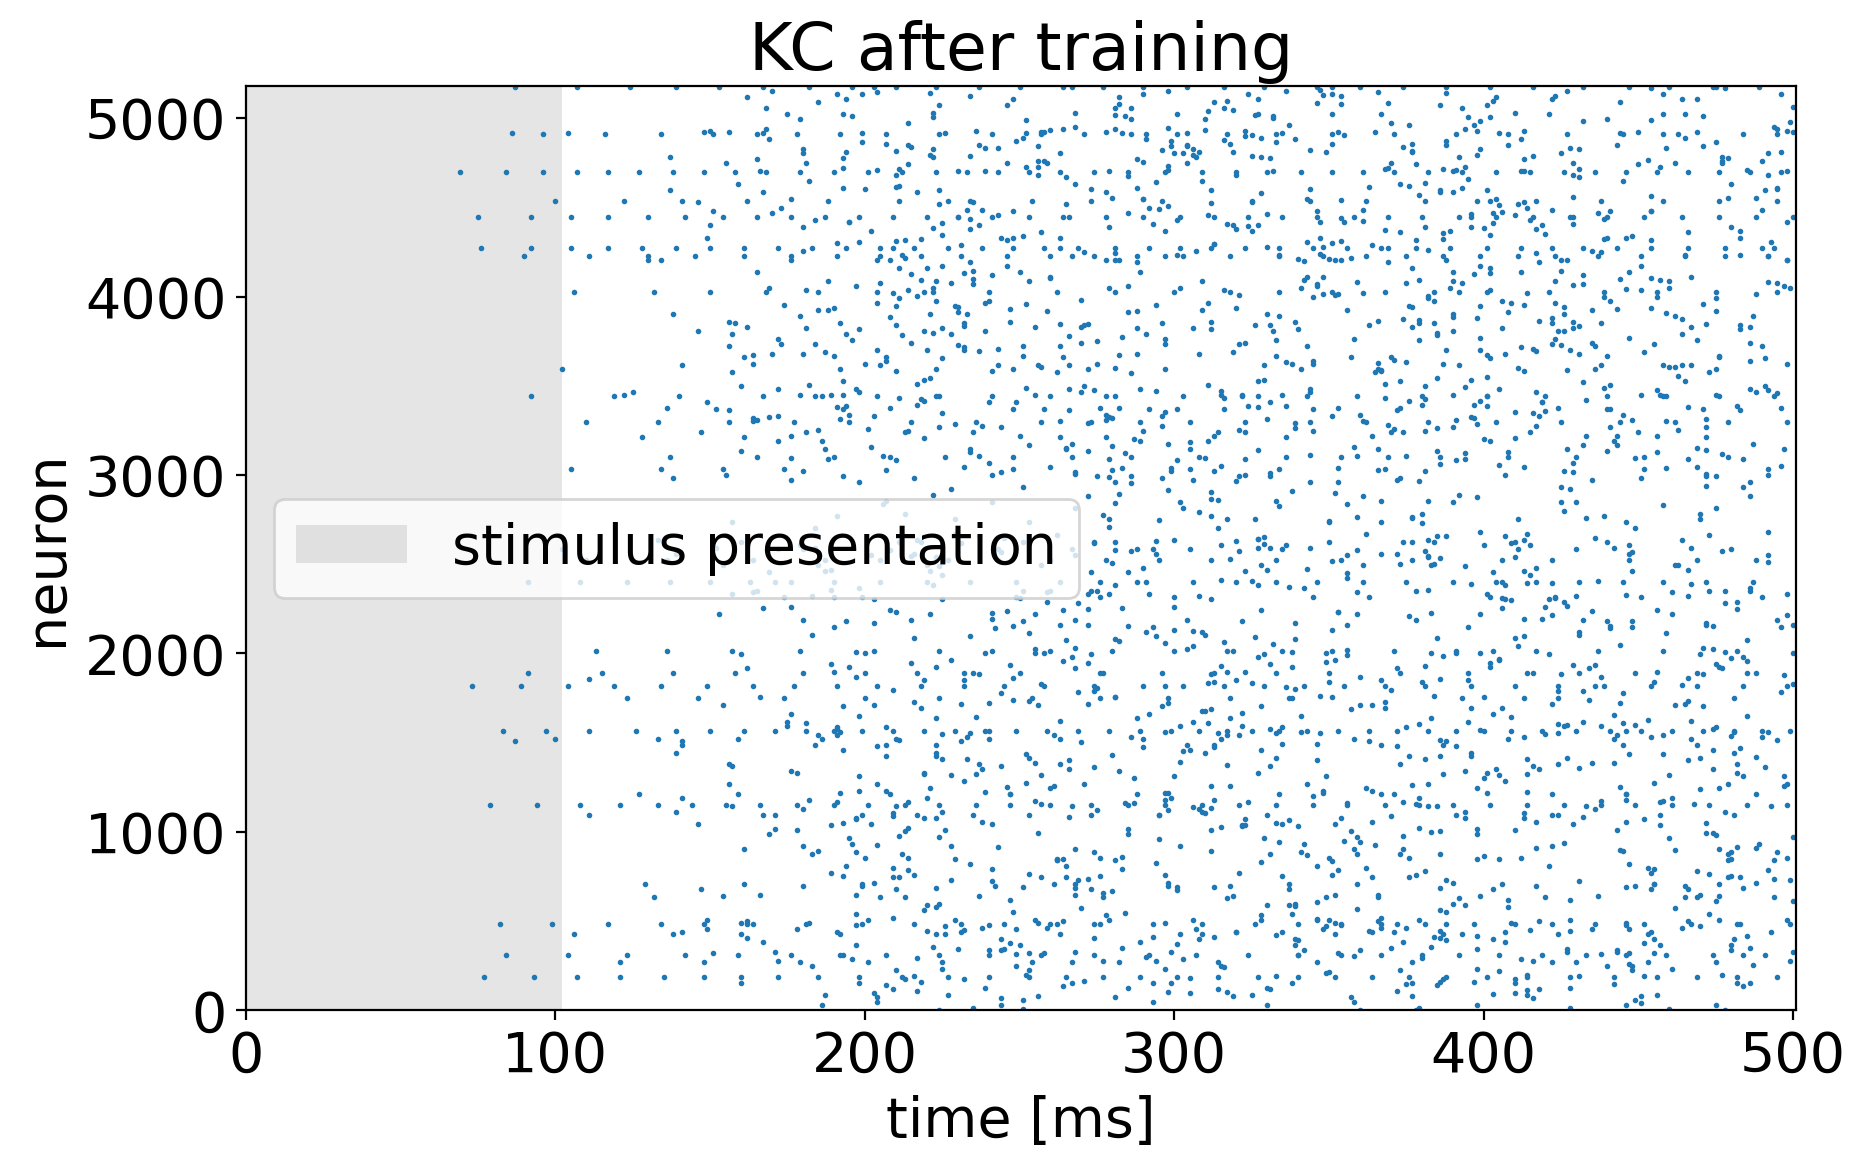

In [41]:
queries=['ALRN','ALPN','KC']
#plot activity in untrained model
plot_celltype_activity(settings, model,fruitfly, queries, pre_path)

In [30]:
'''print('in process run')
model_inst=get_inst(i,padding=3)

run, identifier, date_str = init_run(
    size_string, seed, 'CC_SNN', '',entity=None
)
trainloader, valloader, testloader, nb_steps = choose_data_params(
    data_set_name, settings, num_workers=0,pre_path=pre_path
) 
data_module = DataModule(trainloader, valloader, testloader)

neuron_synapse=f'{settings.neuron_name}_{settings.synapse.__name__}'

if pre_path !='':
    pre_path+='/'
model_path=f"results/{model_inst}"
os.makedirs(model_path, exist_ok = True) 

run.log_model(path=model_path, name=f'{identifier}_{model_inst}')

print(f'trying to log to model path: {model_path}')
if pre_path !='':
            pre_path+='/'

logger = WandbLogger(project='CC_SNN',save_dir ='CC_SNN',
    name=f"",
    version=f"{model_inst}",log_model="all")

#redefine model with overwritten settings
model = Lightning_SNN(
    net_size=settings.net_size,
    neuron_fct=settings.neuron_fct,
    neuron_intrinsic=settings.neuron_intrinsic,
    synapse_intrinsic=settings.synapse_intrinsic,
    train_intrinsic=settings.train_intrinsic,
    clip_intrinsic=settings.clip_intrinsic,
    regularizers=settings.regularizers,
    train_out=settings.train_out,
    train_hidden=settings.train_hidden,
    weight_info=settings.weight_info,
    nr=i,
    learning_rate=settings.learning_rate,
    time_step=settings.time_step,
    optim_class=settings.optim_class,
    optim_params=settings.optim_params,
    scheduler=settings.scheduler,
    surr_grad_scale=settings.surr_grad_scale,
    adapt_intrinsic=False,#TODO
    tau_mem_LIF=settings.tau_mem,
    training_mode = settings.training_mode,
    hidden_mode=settings.hidden_mode,
    target_model = settings.target_model,
    params_from_target = settings.params_from_target,
    hidden_in_loss = settings.hidden_in_loss,
    hidden_loss_scale=settings.hidden_loss_scale,
    noise=settings.noise,
    path_info=None,
    N_train_only_weights = settings.N_train_only_weights,
    shuffle=False
)

print('past model init')
wandb.watch(model, log='all', log_freq=40)


print(f'logging checkpoints to {model_path}')

if torch.cuda.is_available():
    print('\n\n cuda available\n\n')
    accelerator = 'auto'
else:
    #lightning detects mps but should use GPU in that case
    accelerator = 'cpu'

trainer = pl.Trainer(
            logger=logger,
            max_epochs=settings.N_epochs,
            accelerator=accelerator,
            #profiler=profiler,
            log_every_n_steps=100000,#higher than actual steps per epoch -> only log at epoch end?
            limit_test_batches=5,  # only one test batch for plots
            check_val_every_n_epoch=1,
            #num_sanity_val_steps=1, #one validation step before training
            #log_every_n_steps = 1,
            #callbacks=[checkpoint_callback,],
        )
wandb.require(experiment="service")
trainer.fit(model=model, train_dataloaders=data_module)  '''

'print(\'in process run\')\nmodel_inst=get_inst(i,padding=3)\n\nrun, identifier, date_str = init_run(\n    size_string, seed, \'CC_SNN\', \'\',entity=None\n)\ntrainloader, valloader, testloader, nb_steps = choose_data_params(\n    data_set_name, settings, num_workers=0,pre_path=pre_path\n) \ndata_module = DataModule(trainloader, valloader, testloader)\n\nneuron_synapse=f\'{settings.neuron_name}_{settings.synapse.__name__}\'\n\nif pre_path !=\'\':\n    pre_path+=\'/\'\nmodel_path=f"results/{model_inst}"\nos.makedirs(model_path, exist_ok = True) \n\nrun.log_model(path=model_path, name=f\'{identifier}_{model_inst}\')\n\nprint(f\'trying to log to model path: {model_path}\')\nif pre_path !=\'\':\n            pre_path+=\'/\'\n\nlogger = WandbLogger(project=\'CC_SNN\',save_dir =\'CC_SNN\',\n    name=f"",\n    version=f"{model_inst}",log_model="all")\n\n#redefine model with overwritten settings\nmodel = Lightning_SNN(\n    net_size=settings.net_size,\n    neuron_fct=settings.neuron_fct,\n    n

In [31]:
spk_rec.shape #batch x time x neurons
#query: ALPN or ORN63a
idx =0 #model.model.hidden_neuron_IDs
spk_rec[0, :, 10:15]

# plot raster ALPN over time

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], grad_fn=<SliceBackward0>)

torch.Size([501, 16, 1, 2264])


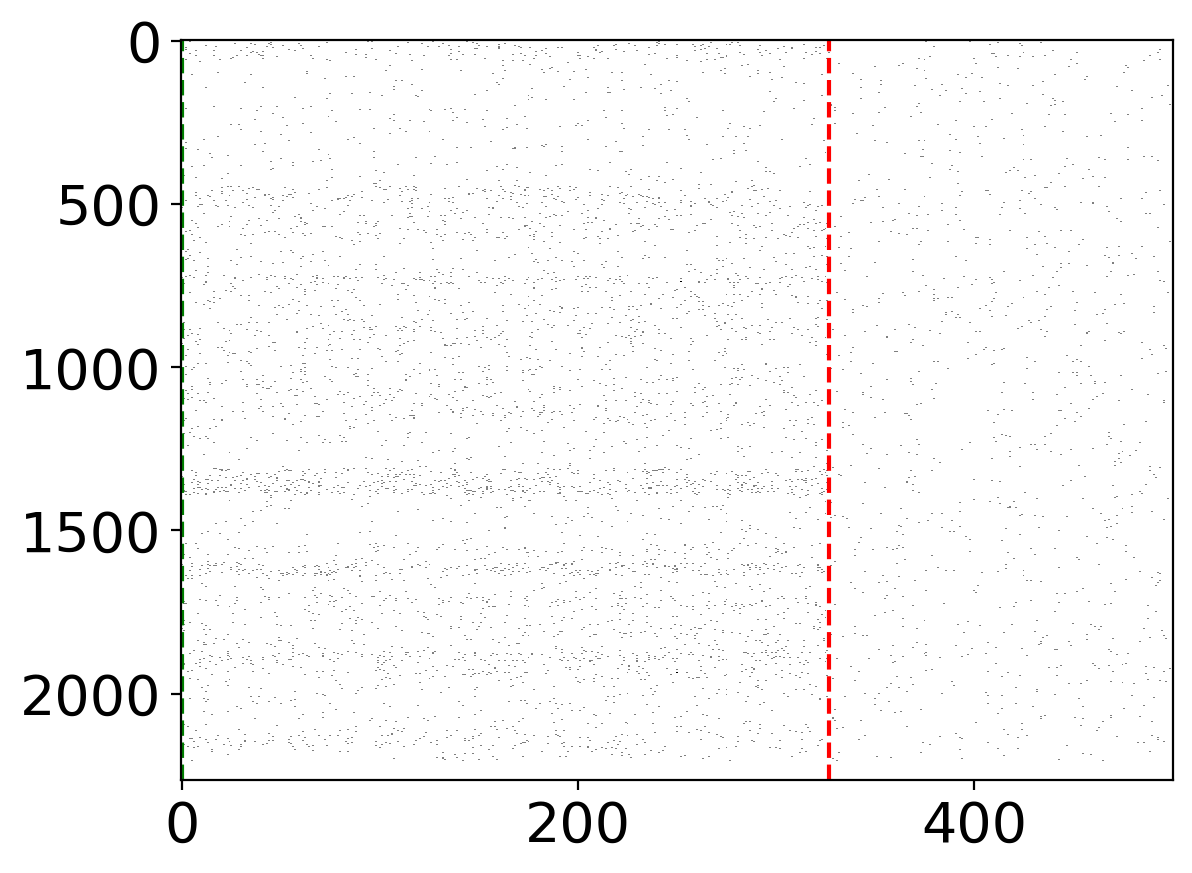

In [32]:
print(inputs.shape)
plt.imshow(inputs[:,0,0,:].detach().numpy().T, cmap="binary",aspect="auto",interpolation='none')
plt.axvline(x=0, color='green', linestyle='--', label='odor onset')
plt.axvline(x=duration[0], color='red', linestyle='--', label='odor offset')

In [33]:
'''
-> code from summerschool visualizations tutorial
fig, ax = plt.subplots(1,1, figsize=(5,2), dpi=dpi)
plot_spikes(*preprocess_spikes(sim.trange(), sim.data[p_spikes]), ax=ax) # try without the preprocess_spikes to see the difference


#####  (Optional) To get axis like in the example figure above:
if True:
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    scalebar_time_len = 0.5
    scalebar_neurons_len = 20  
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    x_data_to_axes = 1.0 / (xlim[1] - xlim[0])
    y_data_to_axes = 1.0 / (ylim[1] - ylim[0]) 
    
    scalebar_time_len_axes = scalebar_time_len * x_data_to_axes
    scalebar_neurons_len_axes = scalebar_neurons_len * y_data_to_axes
    
    # Add short horizontal scale bar (time)
    ax.plot(
        [0.01*scalebar_time_len, 0.01*scalebar_time_len + scalebar_time_len], [-0.05, -0.05],
        color='black', lw=1, clip_on=False
    )
    ax.text(
        0.5*scalebar_time_len, -5, f'{scalebar_time_len} sec.',
        ha='center', va='bottom', fontsize=8
    )
    
    # Add short vertical scale bar (neurons)
    ax.plot(
        [-0.05, -0.05], [0.01*scalebar_neurons_len, 0.01*scalebar_neurons_len + scalebar_neurons_len],
        color='black', lw=1, clip_on=False
    )
    ax.text(
        -0.15, 0.05*scalebar_neurons_len,
        f'{scalebar_neurons_len} neurons',
        ha='center', va='bottom', rotation=90, fontsize=8
    )
else:
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Neuron #")
##### 

plt.tight_layout()'''

'\n-> code from summerschool visualizations tutorial\nfig, ax = plt.subplots(1,1, figsize=(5,2), dpi=dpi)\nplot_spikes(*preprocess_spikes(sim.trange(), sim.data[p_spikes]), ax=ax) # try without the preprocess_spikes to see the difference\n\n\n#####  (Optional) To get axis like in the example figure above:\nif True:\n    ax.set_xticks([])\n    ax.set_yticks([])\n    for spine in ax.spines.values():\n        spine.set_visible(False)\n    \n    scalebar_time_len = 0.5\n    scalebar_neurons_len = 20  \n    \n    xlim = ax.get_xlim()\n    ylim = ax.get_ylim()\n    \n    x_data_to_axes = 1.0 / (xlim[1] - xlim[0])\n    y_data_to_axes = 1.0 / (ylim[1] - ylim[0]) \n    \n    scalebar_time_len_axes = scalebar_time_len * x_data_to_axes\n    scalebar_neurons_len_axes = scalebar_neurons_len * y_data_to_axes\n    \n    # Add short horizontal scale bar (time)\n    ax.plot(\n        [0.01*scalebar_time_len, 0.01*scalebar_time_len + scalebar_time_len], [-0.05, -0.05],\n        color=\'black\', lw=1, cl

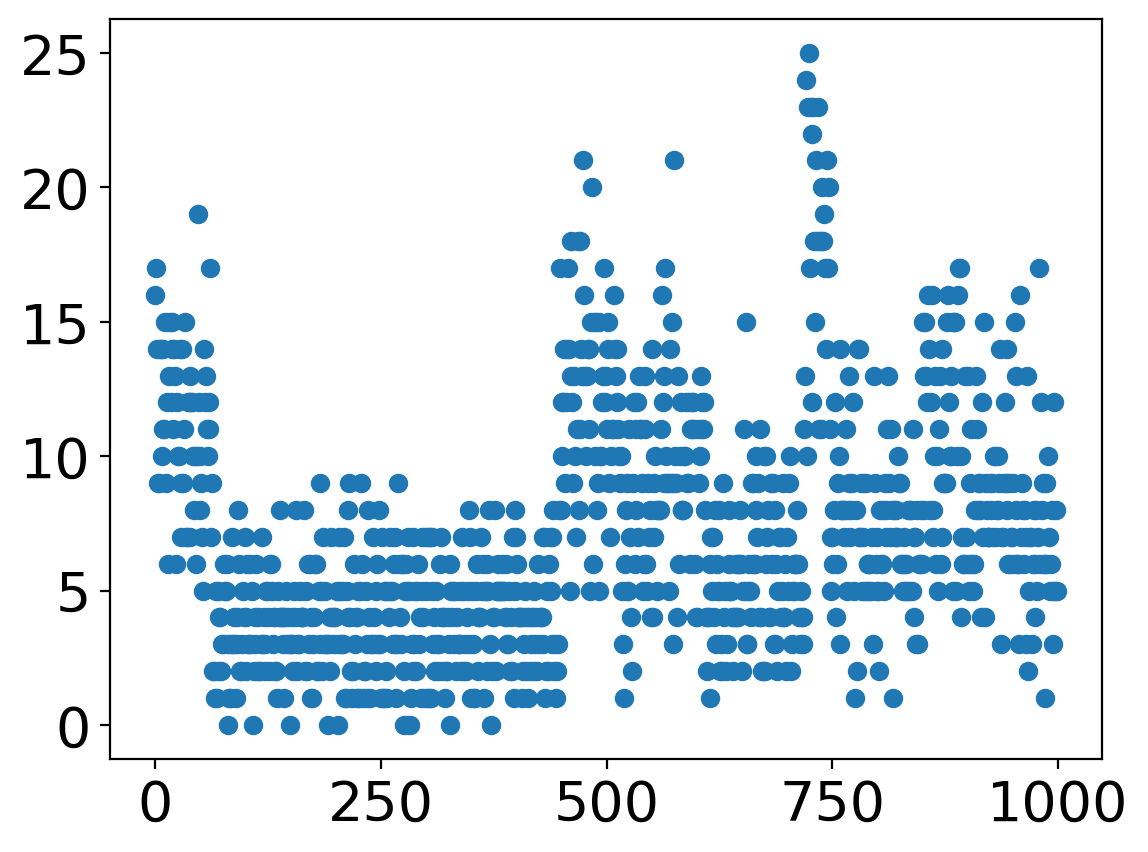

In [34]:
plt.scatter(np.arange(1000),inputs[:,0,0,:1000].detach().numpy().T.sum(1))

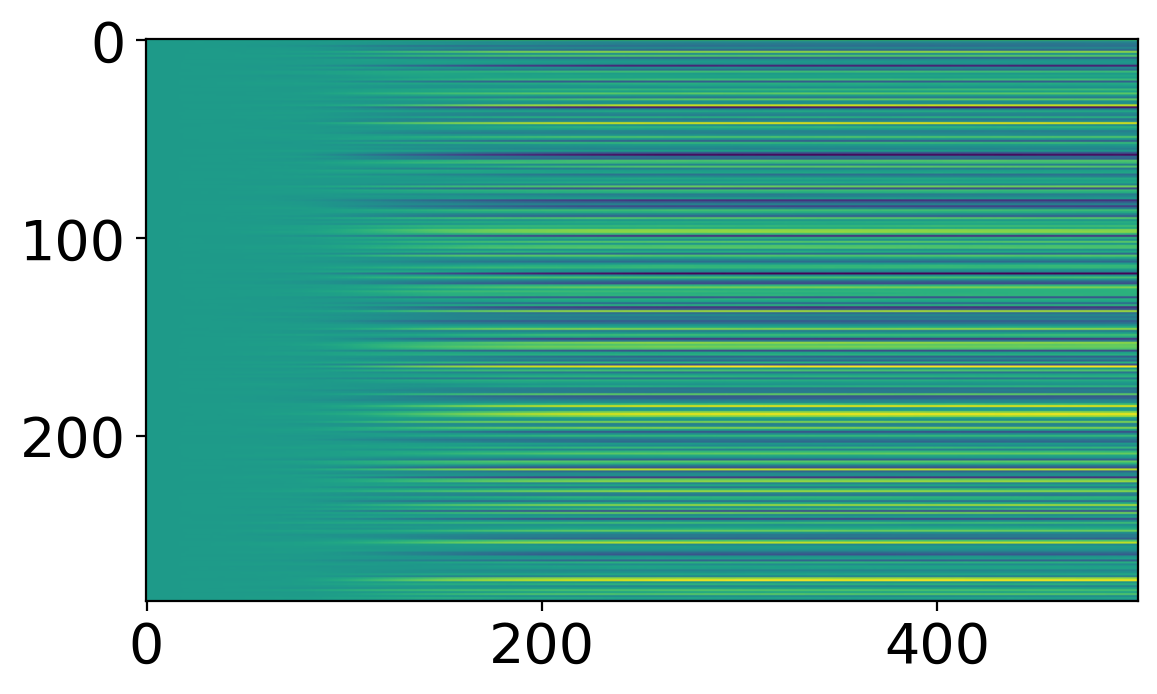

In [35]:
output.shape
plt.imshow(output[0,:,:].T.detach().numpy())

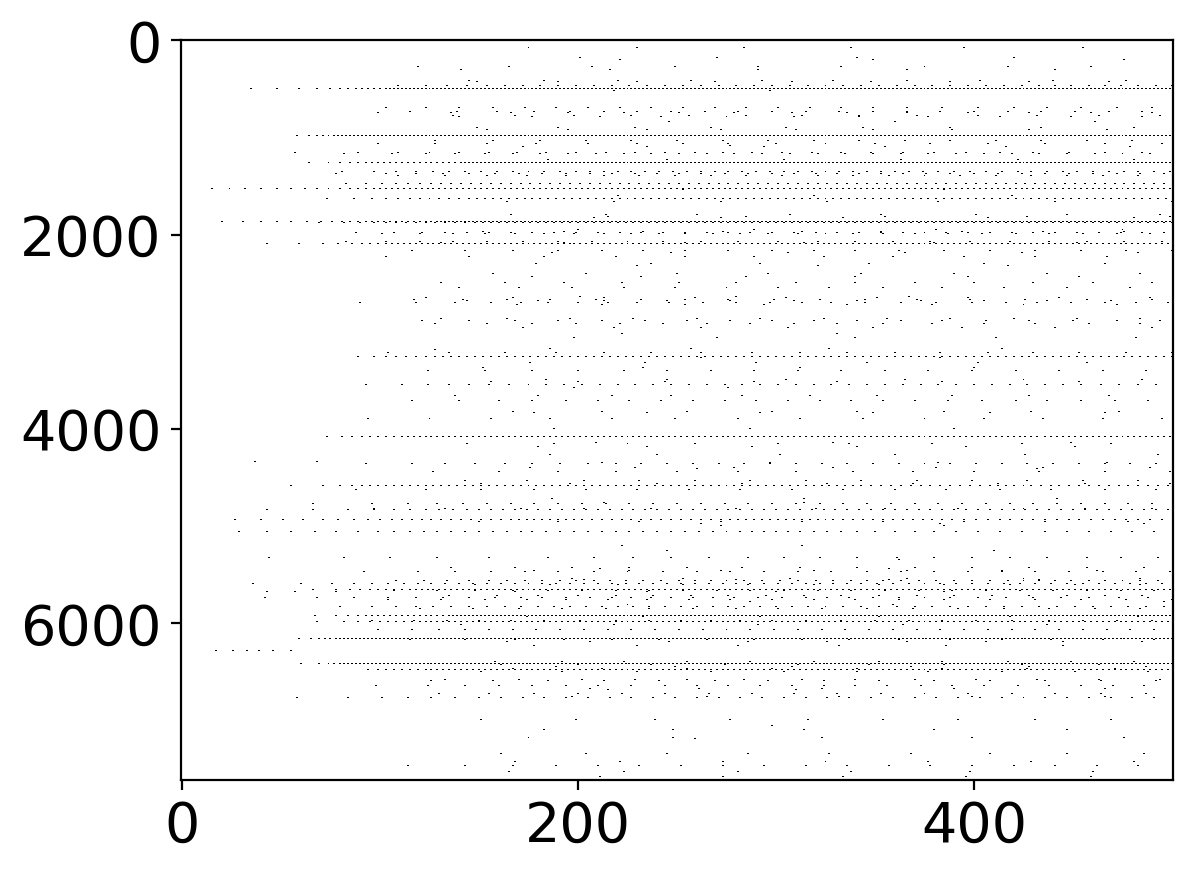

tensor(697635., grad_fn=<SumBackward0>)


In [36]:

plt.imshow(spk_rec[0,:,:].detach().numpy().T, cmap="binary",aspect="auto",interpolation='none')
plt.show()
print(torch.sum(spk_rec))

In [37]:
M = len(target)  # nr of hidden neurons
spikes_per_neuron = spk_rec[:M, :, :].sum(
    axis=1
)  # sum over time, :M -> in case of padding, use only 'real' hidden layer activities
spikes_per_neuron.mean()

tensor(5.7251, grad_fn=<MeanBackward0>)

In [38]:
def get_acc(output, target, N=256):
    m, _ = torch.max(output, 1)
    _, am = torch.max(m, 1)  # argmax over output units
    acc = np.mean((target == am[:N]).detach().cpu().numpy())  # compare to labels
    return acc

get_acc(output, target)

0.0